# Exploratory Data Analysis of FCDO Trucks Project

---

Fan Grayson

For Code Review

## Introduction

This mini-project is a case study of the ["Detecting Trucks in East Africa"](https://datasciencecampus.ons.gov.uk/detecting-trucks-in-east-africa/) project done by the ONS and the FCDO.

This mini-project includes the following data provided by the ONS:

1. __Images:__ .tiff images from the Sentinel 2 satellite of the A1 road north of Windhoek, Namibia, edited by the ONS
2. __Image chips:__ NumPy masked arrays encoding small sections of the images from the satellite images
3. __Tabular data:__ .csv table containing information for a selection of image pixels, with additional features the ONS has inferred

This notebook explores each of these data

## Setup

Importing packages and setting up notebook

In [1]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tifffile as tf
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
fontprops = fm.FontProperties(size=15)

## Image Data

 - Satellite image from Sentinel 2 (open source, updated every 5-10 days)
 - Image is of stretch of A1 road north of Windhoek, Namibia
 - Pixels that are not of the A1 road have been masked and removed
 - Pixels that have a high cloud coverage have also been masked and removed
 - Data is given in the .tiff file format
 - There are 4 channels (layers) in each image:
    1. `blue`
    2. `green`
    3. `red`
    4. near-infrared
    [(see here)](https://gisgeography.com/sentinel-2-bands-combinations/)
 - Each pixel is 10 x 10 m

In [2]:
# Loading all available tiff images in ../data as masked numpy arrays
image_filenames = [x for x in os.listdir("../data") if x.endswith(".tif")]
images = [
    np.ma.masked_values(tf.imread(os.path.join("..", "data", f)), -999.00)
    for f in image_filenames
    ]

In [3]:
def plot_tiff_image(
        image: np.array,
        x_min:int = 0,
        x_max:int = None,
        y_min:int = 0,
        y_max:int = None,
        channels:list = [2,1,0], # channels are 0: blue, 1: green, 2: red
        background:float = 0.5,
        title:str = "",
        ):
    """Plots satellite image from numpy array"""

    # Either one (monochrome) or three (RGB) channels

    if not isinstance(channels, list):
        channels = list(channels)

    assert (len(channels) == 1) or (len(channels) == 3)

    fig, ax = plt.subplots()
    fig.set_figheight(30)

    ax.imshow(image[y_min:y_max, x_min:x_max, channels].filled(background))
    ax.set_title(title)
    ax.set_axis_off()

    scalebar = AnchoredSizeBar(ax.transData,
                            100, '1 km', 'upper right', 
                            pad=0.5,
                            color='white',
                            frameon=False,
                            size_vertical=5,
                            fontproperties=fontprops)

    ax.add_artist(scalebar)

    plt.show()

The entire (edited) image looks like this:

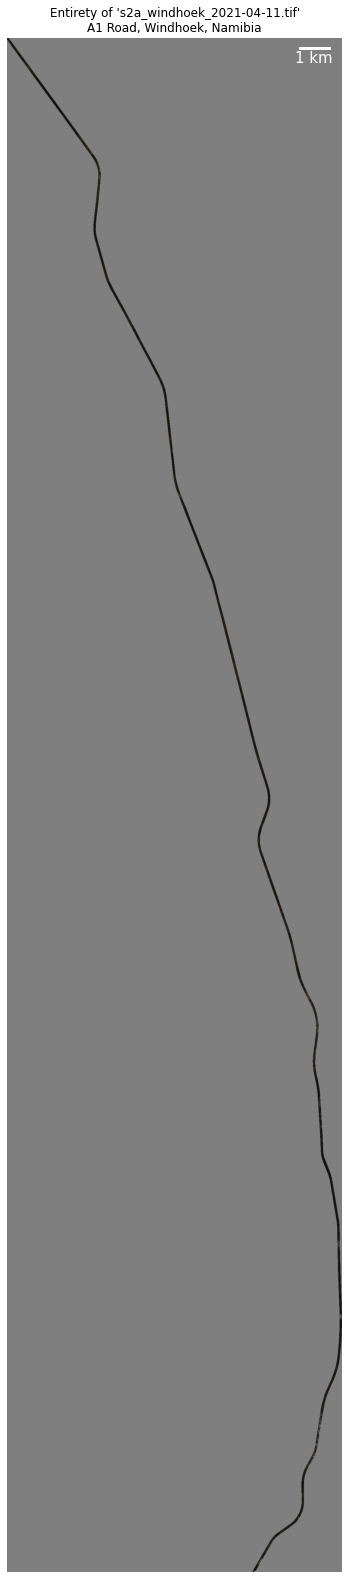

In [4]:
plot_tiff_image(images[0], title=f"Entirety of '{image_filenames[0]}'\nA1 Road, Windhoek, Namibia")

We can focus on a small section of road

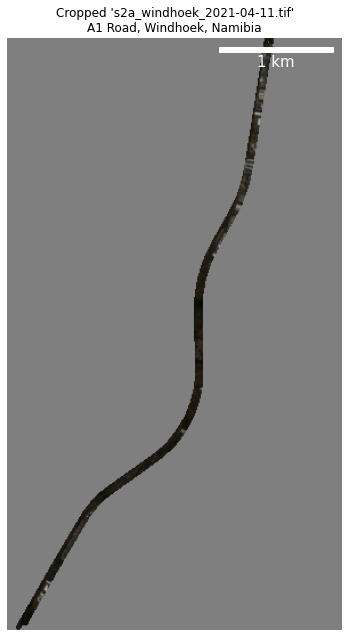

In [5]:
plot_tiff_image(images[0], x_min=780, y_min=4400, title=f"Cropped '{image_filenames[0]}'\nA1 Road, Windhoek, Namibia")

 - Looking closer, we can see some of the possible 'rainbow effect' of large vehicles.
 - This happens since there is a delay in the satellite capturing Red, Green, and Blue channels
 - So large moving pixels will have a 'rainbow effect' (see the [ONS article for more information](https://datasciencecampus.ons.gov.uk/detecting-trucks-in-east-africa/))

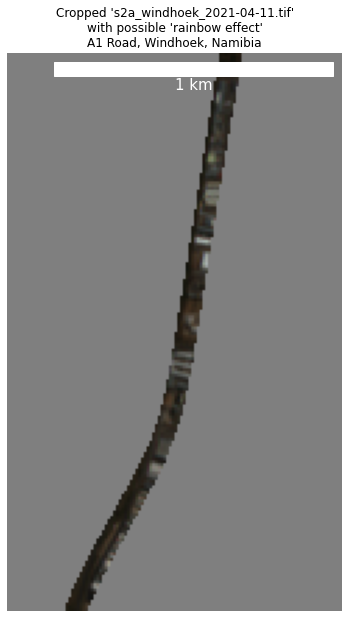

In [6]:
plot_tiff_image(images[0], x_min=930, x_max=1050, y_min=4400, y_max=4600, title=f"Cropped '{image_filenames[0]}'\nwith possible 'rainbow effect'\nA1 Road, Windhoek, Namibia")

## Image Chips

We split the .tiff images above into smaller rectangular sections.
For each section, some feature engineering is done to infer some additional features from three of the original four channels - `blue`, `green`, and `red`.
We then mask the pixels that do not correspond to the A1 road,
and save this as a masked NumPy array object.
We call these objects __'image chips'__.
This process is explained in the `ONS/Trucks_modelling.ipynb` notebook,
but the code to do this has not been included in this mini-project.

The layers of each image chip correspond to the following 28 bands:

 1. `blue`
 2. `green`
 3. `red`
 4. `bg_change`
 5. `br_change`
 6. `bg_z`
 7. `br_z`
 8. `bg_pixel`
 9. `br_pixel`
 10. `hue`
 11. `sat`
 12. `val`
 13. `green_max`
 14. `red_max`
 15. `green_max_temp`
 16. `red_max_temp`
 17. `greenblue_max`
 18. `redblue_max`
 19. `greenblue_max_temp`
 20. `redblue_max_temp`
 21. `green_max5`
 22. `red_max5`
 23. `green_max_temp5`
 24. `red_max_temp5`
 25. `greenblue_max5`
 26. `redblue_max5`
 27. `greenblue_max_temp5`
 28. `redblue_max_temp5`

We can load an example image chip in and take a look:

In [7]:
image_chip_filenames = os.listdir("../data/chips/")

In [8]:
i = 11
image_chip = np.load(os.path.join("../data/chips", image_chip_filenames[i]), allow_pickle=True)
print(image_chip_filenames[i])
image_chip.shape

windhoek_2021-04-21__384_8320


(28, 128, 128)

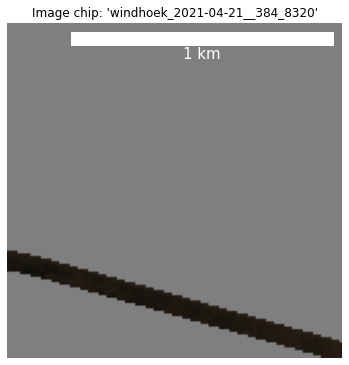

In [9]:
plot_tiff_image(image=image_chip[[0,1,2], :, :].T, title=f"Image chip: '{image_chip_filenames[i]}'")

## Tabular Dataset

The ONS has gone through and identified areas in the image chips that depict the rainbow effect (i.e. a truck).
They choose one pixel from each rainbow effect area and label this pixel as a truck (`ml_class = 1`) - this is so we don't double count trucks. All other pixels are labelled `ml_class = 0`.
They then create a tabular dataset from the image chips with truck labels.
Each pixel from each image chip is treated as a new row.
For each row, there are columns for date, location, the data from the 28 channels, and the label data (`ml_class`).

They then removed any of the pixels that have been masked (cloud or off-road pixels) and randomly selected a subset of pixels to create the `all_training_features.csv` table.

Again, the code to produce this has not been included in this mini-project.

We load in the tabular data:

In [10]:
# load in the features csv file
df = pd.read_csv("../data/all_training_features.csv")

In [11]:
print(f"Number of entries: {len(df)}")

Number of entries: 166969


In [12]:
# Exploring first few rows
df.head(3)

,date,location,blue,green,red,bg_change,br_change,bg_z,br_z,bg_pixel,...,redblue_max_temp,green_max5,red_max5,green_max_temp5,red_max_temp5,greenblue_max5,redblue_max5,greenblue_max_temp5,redblue_max_temp5,ml_class
0,2019-10-01,nairobi,1.0536,0.9664,0.9328,1.053600,1.053600,1.053600,1.053600,1.053600,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-12-14,nairobi,0.0999,0.1226,0.1362,-0.012760,-0.005751,-0.666817,-0.270743,-0.102022,...,193.0,175.0,155.0,183.0,168.0,195.0,177.0,166.0,193.0,0.0
2,2020-12-14,nairobi,0.0954,0.1102,0.1282,0.009269,-0.003518,0.125706,-0.203395,-0.071984,...,195.0,229.0,171.0,232.0,180.0,183.0,202.0,189.0,195.0,0.0


In [13]:
# Print out engineered features
set("_".join(c.split("_")[1:]) for c in df.columns)

{'', 'change', 'class', 'max', 'max5', 'max_temp', 'max_temp5', 'pixel', 'z'}

We check for completeness of data:

In [14]:
print(f"Number of cells with missing data: {df.isna().sum().sum()}")

Number of cells with missing data: 0


We check for any duplicate entries:

In [15]:
print(f"Number of rows that are duplicate entries: {df.duplicated().sum()}")

Number of rows that are duplicate entries: 10


Showing first 2 pairs of duplicate rows:

In [16]:
df.loc[df.duplicated(keep=False)].sort_values(["blue", "green", "red"]).head(4)

,date,location,blue,green,red,bg_change,br_change,bg_z,br_z,bg_pixel,...,redblue_max_temp,green_max5,red_max5,green_max_temp5,red_max_temp5,greenblue_max5,redblue_max5,greenblue_max_temp5,redblue_max_temp5,ml_class
91681,2019-01-29,nairobi,0.1234,0.1434,0.1610,0.1234,0.1234,0.1234,0.1234,0.1234,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
150620,2019-01-29,nairobi,0.1234,0.1434,0.1610,0.1234,0.1234,0.1234,0.1234,0.1234,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38416,2019-03-25,nairobi,0.1250,0.1470,0.1788,0.1250,0.1250,0.1250,0.1250,0.1250,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97821,2019-03-25,nairobi,0.1250,0.1470,0.1788,0.1250,0.1250,0.1250,0.1250,0.1250,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Keep only the first entry for each duplicate:

In [17]:
df = df.drop(df.index[df.duplicated()]).reset_index(drop=True)
print(f"New dataset size: {len(df)}")

New dataset size: 166959


We check the balance of truck to non truck pixels:

In [18]:
# Check Imbalance:
print(f"Class 1: {sum(df.ml_class == 1.0)} ({round(100 * sum(df.ml_class == 1.0) / len(df), 2)}%)")
print(f"Class 0: {sum(df.ml_class == 0.0)}")

Class 1: 365 (0.22%)
Class 0: 166594


This is a highly imbalanced dataset (intuitively, the majority of the non-masked pixels in the image are not trucks)